# FOM Optimization

#### Todo:

- Determine FOM values for collective and band fitting
- Determine FOM values for sifto results
- Drop targets that disagree SNID vs SDSS
- Dertermine classifications for each obj and apply data cuts


In [46]:
import sys

import numpy as np
import pandas as pd
from astropy.table import Table
from pathlib import Path
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import minimize
from sndata.csp import dr3
from sndata.sdss import sako18
from tqdm import tqdm

sys.path.insert(0, '../')
from phot_class import fom
from phot_class.utils import split_data


In [2]:
dr3.download_module_data()
sako18.download_module_data()


# SNR Distributions

In [3]:
def get_csp_snr():
    """Return a 2d array of SNR ratios for each CSP DR3 target"""
    
    blue_snr = []
    red_snr = []
    for data_table in dr3.iter_data(verbose=True):
        blue_data, red_data = split_data(
            data_table, dr3.band_names, dr3.lambda_effective, data_table.meta['z'])
        
        blue_snr.extend(blue_data['flux'] /  blue_data['fluxerr'])
        red_snr.extend(red_data['flux'] /  red_data['fluxerr'])
        
    return np.array(blue_snr), np.array(red_snr)


In [4]:
def get_sdss_snr(subset=['SNIa']):
    """Return a 2d array of SNR ratios for each SDSS Sako18 target
    
    Args:
        subset (list): Only consider targets having the
                       given Sako18 classifications
    """
    
    master = sako18.load_table('master')
    is_sn = np.isin(master['Classification'], subset)

    sdss_obj_ids = master['CID'][is_sn]

    blue_snr = []
    red_snr = []
    for obj_id in tqdm(sdss_obj_ids):
        data_table = sako18.get_data_for_id(obj_id)
        blue_data, red_data = split_data(
            data_table, sako18.band_names, sako18.lambda_effective, data_table.meta['z'])
        
        blue_snr.extend(blue_data['flux'] /  blue_data['fluxerr'])
        red_snr.extend(red_data['flux'] /  red_data['fluxerr'])
        
    return np.array(blue_snr), np.array(red_snr)


In [5]:
csp_blue_snr, csp_red_snr = get_csp_snr()
csp_flat = np.concatenate([csp_blue_snr, csp_red_snr])

sdss_blue_snr, sdss_red_snr = get_sdss_snr()
sdss_flat = np.concatenate([sdss_blue_snr, sdss_red_snr])


  1%|          | 5/499 [00:00<01:12,  6.82it/s]/home/djperrefort/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|██████████| 499/499 [00:40<00:00, 12.34it/s]


In [6]:
def hist_snr_distributions(csp_snr_arr, sdss_snr_arr):
    """Plot SNR histograms for CSP and SDSS
    
    Args:
        csp_snr_arr  (ndarray): Flatt array of CSP SNR values
        sdss_snr_arr (ndarray): Flatt array of SDSS SNR values
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    ax1.hist(sdss_snr_arr, bins=np.arange(0, 40, 1), label='SDSS', density=False)
    ax2.hist(csp_snr_arr, label='CSP', color='C1', density=False)

    for survey_data, axis in zip([sdss_snr_arr, csp_snr_arr], (ax1, ax2)):
        median = np.median(survey_data)
        average = np.average(survey_data)
        axis.axvline(median, color='k', linestyle='--', label=f'median {median:.2f}')
        axis.axvline(average, color='k', linestyle=':', label=f'average {average:.2f}')

        axis.set_xlabel('SNR')
        axis.legend()


Text(0.5, 0.98, 'All bands')

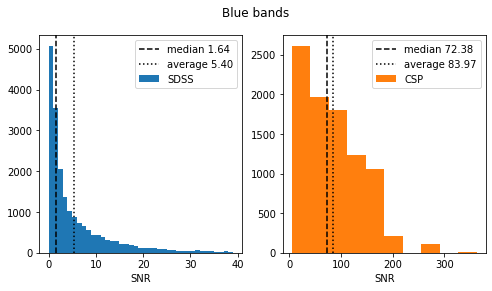

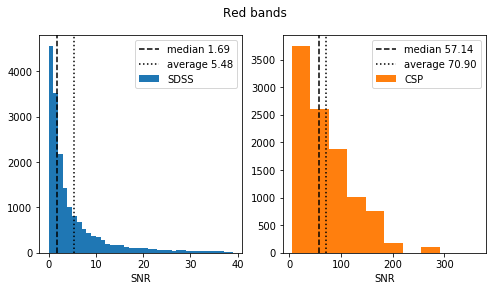

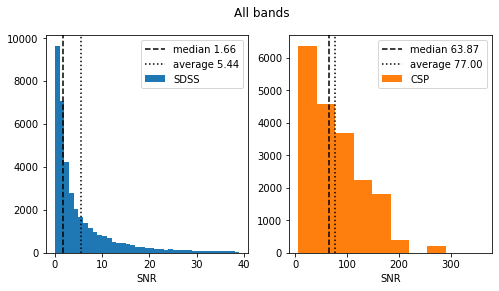

In [7]:
hist_snr_distributions(csp_blue_snr, sdss_blue_snr)
plt.gcf().suptitle('Blue bands')

hist_snr_distributions(csp_red_snr, sdss_red_snr)
plt.gcf().suptitle('Red bands')

hist_snr_distributions(csp_flat, sdss_flat)
plt.gcf().suptitle('All bands')


In [8]:
scale_func = np.median
blue_scale_factor =  scale_func(sdss_blue_snr) / scale_func(csp_blue_snr)
red_scale_factor =  scale_func(sdss_red_snr) / scale_func(csp_red_snr)
all_scale_factor =  scale_func(sdss_flat) / scale_func(csp_flat)

blue_scale_factor, red_scale_factor, all_scale_factor


(0.02267518871386355, 0.02952491421942996, 0.026055651708632818)

## Scaling Classification Coordinates

In [9]:
def get_csp_coords(results_dir):
    """Load CSP classification coordinates
    
    Args:
        results_dir (Path): Directory containing CSP fit results
    """

    # Load fitted coordinates
    csp_path = results_dir / 'csp_dr3_simple_fit_class.ecsv'
    csp_coords = Table.read(csp_path).to_pandas('obj_id')
    csp_coords['survey'] = 'CSP'

    # Load published subtypes from DR3
    csp_classes = dr3.load_table(2).to_pandas('SN')
    csp_classes = csp_classes.drop(
        ['Dm15(tem)1', 'e_Dm15(tem)1', 'Nopt', 'NIR', 'Tspec', 'Subtype2', 'Subtype3'], axis='columns')
    
    csp_classes = csp_classes.rename({'Subtype1': 'subType'}, axis='columns')
    
    csp_classes = csp_classes.replace('---', 'unknown')  # Objects missing subtypes
    csp_classes = csp_classes.replace('normal', 'Ia-norm')
    csp_classes = csp_classes.replace('91bg-like', 'Ia-91bg')
    csp_classes = csp_classes.replace('91T-like', 'Ia-91T')
    csp_classes['type'] = csp_classes.subType.replace({
        'Ia-norm': 'Ia',
        'Ia-91bg': 'Ia',
        'Ia-91T': 'Ia',
        'Iax': 'Ia'
    })
    
    return csp_coords.join(csp_classes)


def get_sdss_coords(results_dir, snid_dir):
    """Load SDSS classification coordinates
    
    Args:
        results_dir (Path): Directory containing SDSS fit results
        snid_path   (Path): Optional directory SNID typing results 
    """
    
    # Load fitted coordinates
    sdss_path = results_dir / 'sdss_sako18_simple_fit_class.ecsv'
    sdss_coords = Table.read(sdss_path).to_pandas('obj_id')
    sdss_coords.index = np.array(sdss_coords.index, dtype=int)
    sdss_coords['survey'] = 'SDSS'
    
    # Add subtypes determined from SNID
    snid_summary = pd.read_csv(snid_results_dir / 'summary.csv', index_col='objId')
    snid_summary['type'] = snid_summary.subType.replace({
        'Ia-norm': 'Ia',
        'Ia-91bg': 'Ia',
        'Ia-91T': 'Ia',
        'Ia-pec': 'Ia',
        'Ia-csm': 'Ia',
        'Ib-norm': 'Ib',
        'Ib-pec': 'Ib',
        'Ic-norm': 'Ic',
        'Ic-broad': 'Ic',
        'IIb': 'II',
        'IIn': 'II',
        'IIL': 'II',
        'IIP': 'II',
        'Gal': 'NotSN',
        'AGN': 'NotSN'
    })
    
    sdss_coords = sdss_coords.join(snid_summary[['subType', 'type', 'SDSSClass']])
    sdss_coords['type'] = sdss_coords.type.fillna('unknown')
    sdss_coords['subType'] = sdss_coords.subType.fillna('unknown')
    sdss_coords['SDSSClass'] = sdss_coords.SDSSClass.fillna('unknown')
    
    return sdss_coords
    

In [10]:
band_results_dir = Path('.').resolve().parent / 'results' / f'band_fits' / 'with_ext'
coll_results_dir = Path('.').resolve().parent / 'results' / f'collective_fits' / 'with_ext'

csp_band_coords = get_csp_coords(band_results_dir)
csp_coll_coords = get_csp_coords(coll_results_dir)

snid_results_dir = Path('.').resolve().parent / 'results' / 'snid'
sdss_band_coords = get_sdss_coords(band_results_dir, snid_results_dir)
sdss_coll_coords = get_sdss_coords(coll_results_dir, snid_results_dir)

# Combine coordinates from SDSS and CSP
band_coordinates = pd.concat([csp_band_coords, sdss_band_coords], sort=True)
band_coordinates = band_coordinates.set_index(['survey', band_coordinates.index])

coll_coordinates = pd.concat([csp_coll_coords, sdss_coll_coords], sort=True)
coll_coordinates = coll_coordinates.set_index(['survey', coll_coordinates.index])

coll_coordinates


SDSSClass    subType       type            x            y
survey                                                                 
CSP    2004ef       NaN    Ia-norm         Ia  -236.441833  -646.652981
       2004eo       NaN    Ia-norm         Ia  -995.835138 -1910.135356
       2004ey       NaN    Ia-norm         Ia -1642.039828 -2410.170836
       2004gs       NaN    Ia-norm         Ia     7.467955   -22.230109
       2004gu       NaN  06gz-like  06gz-like  -131.247937  -735.425562
...                 ...        ...        ...          ...          ...
SDSS   9895     unknown    unknown    unknown     0.213250    -1.011629
       9954     unknown    unknown    unknown   -12.946534    -1.760000
       996      unknown    unknown    unknown     4.668333   -31.621944
       9962     unknown    unknown    unknown     0.115471    -0.187754
       999      unknown    unknown    unknown    -6.934400    -0.434050

[5468 rows x 5 columns]

In [59]:
def hist_coord_distributions(
        coord_df, 
        blue_scale,
        red_scale,
        csp_bins=None, 
        sdss_bins=np.arange(-100, 100, 2.5),
        figsize=(8, 4)):
    """Plot histogram of classification coords for CSP adnd SDSS
    
    ``coord_df`` should have columns ``x`` and ``y`` and be indexible
    by survey (``CSP`` and ``SDSS``).
    
    Args:
        coord_df (dataframe): Dataframe of classification coordinates
        scale        (float): Rescale csp coordinates by the given value
        csp_bins   (ndarray): Bins to use when plotting the CSP histogram
        sdss_bins  (ndarray): Bins to use when plotting the CSP histogram
        figsize      (tuple): Size of the figure in inches
    """
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    for coord, scale, axis in zip('xy', (blue_scale, red_scale), axes):
        csp_vals = coord_df.loc['CSP'][coord]
        csp_median = np.median(csp_vals)
        sdss_vals = coord_df.loc['SDSS'][coord]
        sdss_median = np.median(sdss_vals)

        axis.hist(csp_vals * scale, bins=csp_bins, density=True, label='csp')
        axis.set_title(f'Scale factor: {scale * 100 :.1f}%')
        axis.legend()
        axis.set_xlabel(f'{coord} Coordinate')
        
        twin_x = axis.twinx()
        twin_x.hist(sdss_vals, density=True, histtype='step', bins=sdss_bins, label='sdss', color='C1')        
        twin_x.set_ylim(0, .01)
    
    axes[0].set_ylabel('Number of CSP targets')
    twin_x.set_ylabel('Number of SDSS targets')
    plt.tight_layout()
    
    return fig, axes
        

Text(0.5, 0.98, 'Band Fitting')

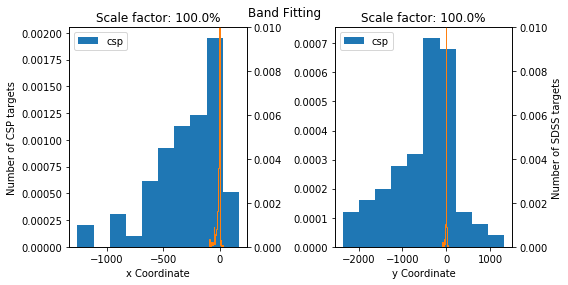

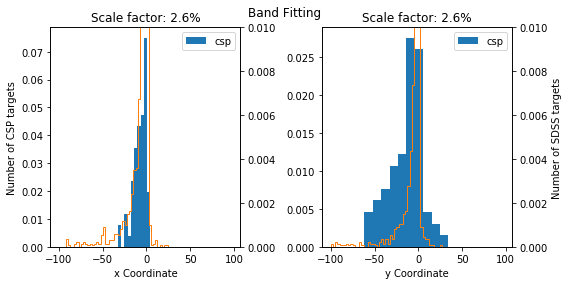

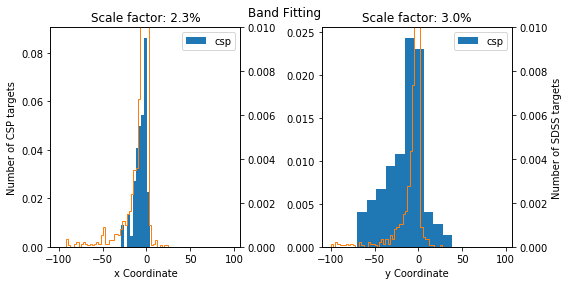

In [60]:
fig, axes = hist_coord_distributions(band_coordinates, 1, 1)
fig.suptitle('Band Fitting')

fig, axes = hist_coord_distributions(band_coordinates, all_scale_factor, all_scale_factor)
fig.suptitle('Band Fitting')

fig, axes = hist_coord_distributions(band_coordinates, blue_scale_factor, red_scale_factor)
fig.suptitle('Band Fitting')


Text(0.5, 0.98, 'Collective Fitting')

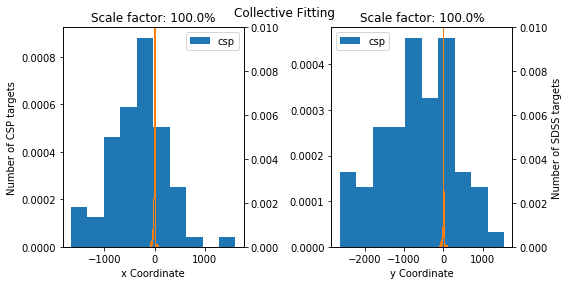

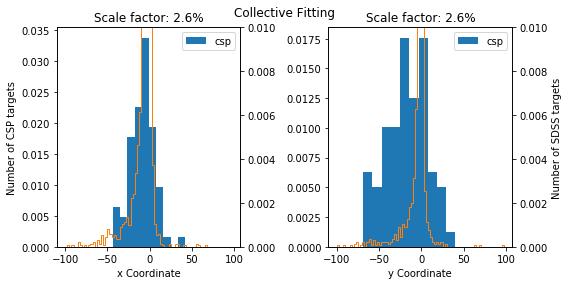

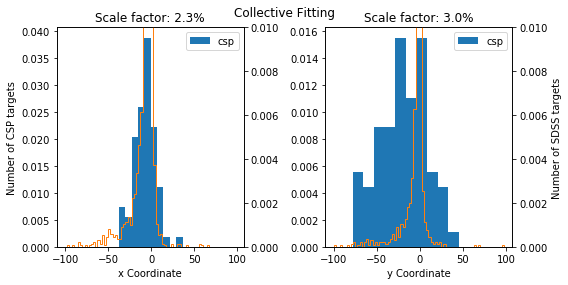

In [61]:
fig, axes = hist_coord_distributions(coll_coordinates, 1, 1)
fig.suptitle('Collective Fitting')

fig, axes = hist_coord_distributions(coll_coordinates, all_scale_factor, all_scale_factor)
fig.suptitle('Collective Fitting')

fig, axes = hist_coord_distributions(coll_coordinates, blue_scale_factor, red_scale_factor)
fig.suptitle('Collective Fitting')


In [83]:
def scatter_class_coordinates(coord_df, blue_scale=1, red_scale=1):
    """Scatter plot classification coordinates
    
    Args:
        coord_df (dataframe): Classification coordinates for CSP and SDSS
        scale        (float): Rescale CSP coordinates by the given value
    """
    
    sdss = coord_df.loc['SDSS']
    csp = coord_df.loc['CSP']
    
    fig, axis = plt.subplots()
    axis.scatter(sdss['x'], sdss['y'], s=10, label='SDSS')
    axis.scatter(csp['x'] * blue_scale, csp['y'] * red_scale, s=5, label='CSP')
    axis.legend()
    
    x_label = r'$\chi^2_{blue}$ (Ia) - $\chi^2_{blue}$ (91bg)'
    y_label = r'$\chi^2_{red}$ (Ia) - $\chi^2_{red}$ (91bg)'
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.set_title(f'Scale factor: x = {blue_scale * 100 :.1f}%, y = {red_scale * 100 :.1f}%')


(-50, 50)

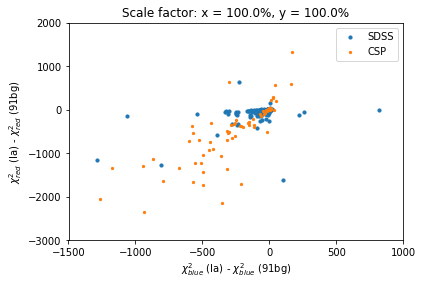

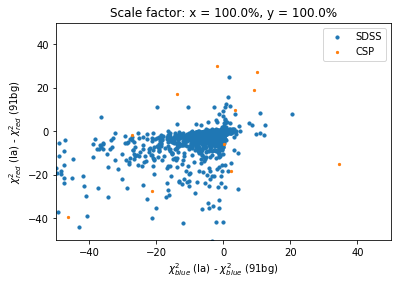

In [84]:
scatter_class_coordinates(band_coordinates)
plt.xlim(-1500, 1000)
plt.ylim(-3000, 2000)

scatter_class_coordinates(band_coordinates)
plt.xlim(-50, 50)
plt.ylim(-50, 50)


(-50, 50)

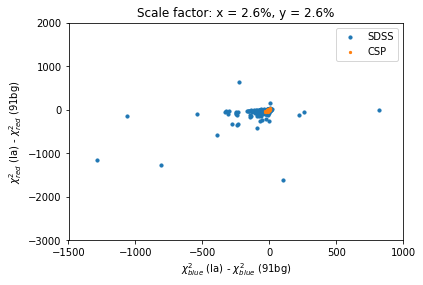

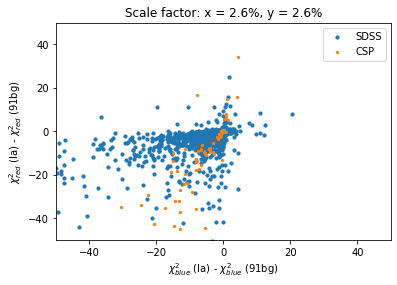

In [85]:
scatter_class_coordinates(band_coordinates, all_scale_factor, all_scale_factor)
plt.xlim(-1500, 1000)
plt.ylim(-3000, 2000)

scatter_class_coordinates(band_coordinates, all_scale_factor, all_scale_factor)
plt.xlim(-50, 50)
plt.ylim(-50, 50)


## FOM 

In [171]:
def imshow_with_cbar(ax, data, **kwargs):
    im = ax.imshow(data, **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    
def plot_fom(fom_coords, blue_scale, red_scale, fom_class='Ia-91bg'):
    
    # fom_coords = coords[coords.subType != 'unknown']
    unknown_coords = fom_coords[fom_coords.subType == 'unknown']
    
    fom_vals = []
    num_points = []
    d1_grid = np.arange(-5, 15, .25)
    for yc in d1_grid:
        fom_vals.append([])
        num_points.append([])
        
        for xc in d1_grid:
            rec_fom = fom.rectangular(
                truth=fom_coords.subType, 
                x=fom_coords.x * blue_scale, 
                y=fom_coords.y * red_scale, 
                x_cutoff=xc, 
                y_cutoff=yc,
                check_type=fom_class)
            
            num = len(unknown_coords[(unknown_coords.x > xc) & (unknown_coords.y > yc)])

            fom_vals[-1].append(rec_fom)
            num_points[-1].append(num)
            
    fom_vals = np.array(fom_vals)
    num_points = np.array(num_points)
    
    fig, (lax, midax, rax) = plt.subplots(1, 3, figsize=(15, 5))
    extent=(d1_grid.min(), d1_grid.max(), d1_grid.min(), d1_grid.max())
    
    imshow_with_cbar(lax, fom_vals, origin='bottom left', aspect='auto', extent=extent)
    lax.set_title('FOM')
    
    imshow_with_cbar(midax, num_points, origin='bottom left', aspect='auto', extent=extent, vmin=0, vmax=25)
    midax.set_title('Number of Points')
    
    rax.scatter(fom_vals, num_points)
    rax.set_ylim(0, 100)
    rax.set_xlabel('FOM')
    rax.set_ylabel('Number of Points')
    plt.tight_layout()


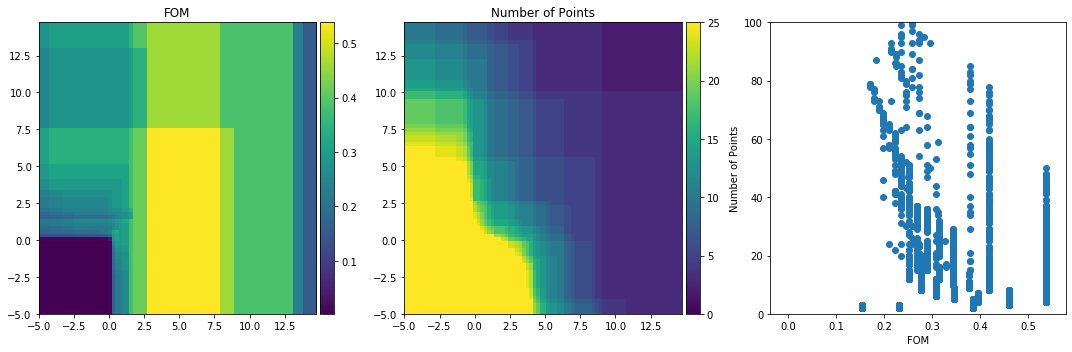

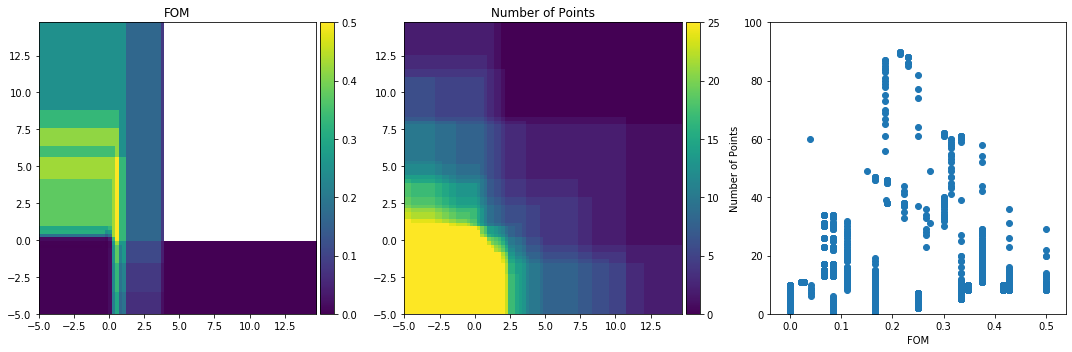

In [172]:
plot_fom(coll_coordinates, blue_scale_factor, red_scale_factor)
plot_fom(band_coordinates, blue_scale_factor, red_scale_factor)


In [173]:
def scatter_fom(coord_df, x_cut=0, y_cut=0, blue_scale=1, red_scale=1, fom=None, figsize=(8, 8)):
    """Scatter plot classification coordinates and include FOM results
    
    Args:
        coord_df (dataframe): Classification coordinates for CSP and SDSS
        x_cut        (float): x cutoff used in FOM calculation
        y_cut        (float): y cutoff used in FOM calculation
        scale        (float): Rescale CSP coordinates by the given value
        figsize      (tuple): Size of the figure in inches
    """
    
    fig, axis = plt.subplots(figsize=figsize)
    for sn_type, dataframe in coord_df.groupby('subType'):
        if sn_type == 'unknown':
            axis.plot(
                dataframe.x, dataframe.y, 
                color='grey', 
                fillstyle='none', 
                linestyle='none',
                marker='o', 
                alpha=.25, 
                zorder=-1)
        
        else:
            label = f'{sn_type} ({len(dataframe)})'
            axis.scatter(dataframe.x * blue_scale, dataframe.y * red_scale, label=label, s=20)
            
    line_kwargs = dict(linestyle='--', color='black', alpha=.5)
    axis.axvline(x_cut, **line_kwargs)
    axis.axhline(y_cut, **line_kwargs, label=f'FOM = {fom: .2f}' if fom else fom)
        
    x_label = r'$\chi^2_{blue}$ (Ia) - $\chi^2_{blue}$ (91bg)'
    y_label = r'$\chi^2_{red}$ (Ia) - $\chi^2_{red}$ (91bg)'
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    
    plt.legend()
    

(-15, 15)

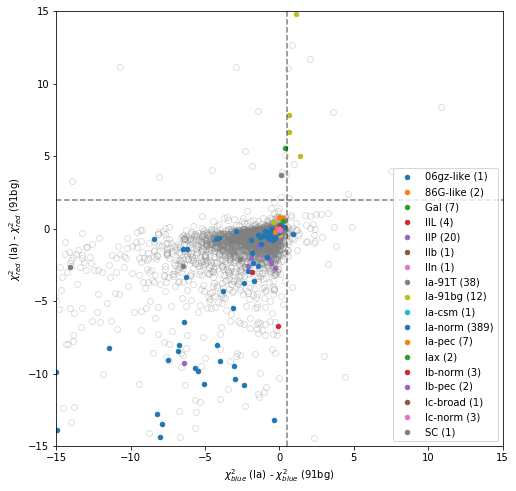

In [174]:
scatter_fom(band_coordinates, .5, 2, all_scale_factor, all_scale_factor)
lim = 15
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)


In [175]:
import itertools

from bokeh.models import Range1d
from bokeh.plotting import figure, show
from bokeh.palettes import Dark2_5 as palette
from bokeh.io import  output_notebook

output_notebook()


Loading BokehJS ...

In [176]:
def bokeh_fom(coord_df, x_cut=0, y_cut=0, scale=1, fom=None, figsize=(8, 8)):
    """Scatter plot classification coordinates and include FOM results
    
    Args:
        coord_df (dataframe): Classification coordinates for CSP and SDSS
        x_cut        (float): x cutoff used in FOM calculation
        y_cut        (float): y cutoff used in FOM calculation
        scale        (float): Rescale CSP coordinates by the given value
        figsize      (tuple): Size of the figure in inches
    """
    
    colors = itertools.cycle(palette) 
    fig = figure(plot_width=800, plot_height=800)
    
    
    for sn_type, dataframe in coord_df.groupby('type'): 
        if sn_type == 'unknown':
            continue
        
        fig.circle(dataframe.x * scale, dataframe.y * scale, color=next(colors))

    fig.ray(x=[y_cut], y=[y_cut], length=0, angle=0, line_width=1, color='black')
    fig.ray(x=[y_cut], y=[y_cut], length=0, angle=np.pi, line_width=1, color='black')
    
    fig.ray(x=[x_cut], y=[x_cut], length=0, angle=-np.pi / 2, line_width=1, color='black')
    fig.ray(x=[x_cut], y=[x_cut], length=0, angle=np.pi / 2, line_width=1, color='black')

    fig.xaxis.axis_label = r'$\chi^2_{blue}$ (Ia) - $\chi^2_{blue}$ (91bg)'
    fig.yaxis.axis_label = r'$\chi^2_{red}$ (Ia) - $\chi^2_{red}$ (91bg)'
    fig.x_range = Range1d(-100, 100)
    fig.y_range = Range1d(-100, 100)
    show(fig)
